# Post-processing for Micro-wrapper development

In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY311,
)

In [2]:
import datetime
import functools
import math
import os
import pickle
import re
import sys

sys.path.insert(1, os.path.abspath(".."))

from enum import IntEnum, unique

import scipy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap
from pint import Quantity
from tqdm.notebook import trange, tqdm, tnrange

import lysis
from lysis.util import Q_

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [3]:
#############################################
#### TODO: Change all this to dataframes that read from CSV
#############################################

scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("total_molecules", int),
        ("pore_size", Quantity),  # in microns. Code requires cm
        (
            "fiber_diameter",
            Quantity,
        ),  # in nanometers. Needs to be added to pore_size to get grid_node_distance
        # ("binding_sites", Quantity),
        ("cols", int),
        ("rows", int),
        ("empty_rows", int),
        ("forced_unbind", float),
        ("average_bound_time", Quantity),
        ("nodes", int),
        ("diss_const_tPA_wPLG", Quantity),
        ("diss_const_tPA_woPLG", Quantity),
    ]
)
mechanism_type = np.dtype(
    [("descriptor", np.str_, 40), ("micro_executable", np.str_, 40), ("macro_executable", np.str_, 40)]
)
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("source_exp", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("micro_seed", np.int64),
        ("macro_seed", np.int64),
    ]
)
lysis_root = os.path.join("/", "home", "bpaynter", "git", "UCO-OpResearch", "lysis")
data_root = os.path.join(lysis_root, "data")

In [4]:
in_file_code = "_{scenario_code}"
out_file_code = "_{scenario_code}"

In [5]:
scenarios = np.array(
    [
        (
            "0.1-PKd",
            43_074,
            Q_("1.0135 um"),
            Q_("72.7 nm"),
            # Q_("427 uM"),
            93,
            121,
            28,
            0.5143,
            Q_("277.8 sec"),
            7,
            Q_("0.002 uM"),
            Q_("0.036 uM"),
        ),
        (
            "1-PKd",
            43_074,
            Q_("1.0135 um"),
            Q_("72.7 nm"),
            # Q_("427 uM"),
            93,
            121,
            28,
            8.52e-2,
            Q_("27.8 sec"),
            7,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "10-PKd",
            43_074,
            Q_("1.0135 um"),
            Q_("72.7 nm"),
            # Q_("427 uM"),
            93,
            121,
            28,
            5.4e-3,
            Q_("2.78 sec"),
            7,
            Q_("0.2 uM"),
            Q_("3.6 uM"),
        ),
        (
            "TN-L__9_350",
            9_350,
            Q_("1.0135 um"),
            Q_("72.7 nm"),
            # Q_("427 uM"),
            93,
            93,
            0,
            0.0852,
            Q_("27.8 sec"),
            7,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TN-D__9_350",
            9_350,
            Q_("0.22 um"),
            Q_("72.7 nm"),
            # Q_("427 uM"),
            342,
            116,
            0,
            0.0852,
            Q_("27.8 sec"),
            7,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TK-L__9_350",
            9_350,
            Q_("1.0135 um"),
            Q_("145.4 nm"),
            # Q_("213 uM"),
            87,
            29,
            0,
            0.0729129,
            Q_("27.8 sec"),
            13,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TK-D__9_350",
            9_350,
            Q_("0.22 um"),
            Q_("145.4 nm"),
            # Q_("213 uM"),
            274,
            42,
            0,
            0.0729129,
            Q_("27.8 sec"),
            13,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TB-xi__21_105",
            21_105,
            Q_("5.34 um"),
            Q_("123 nm"),
            # Q_("248.531 uM"),
            19,
            184,
            83,
            0.077725,
            Q_("27.8 sec"),
            11,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TF-x__9_951",
            9_951,
            Q_("2.5 um"),
            Q_("105.1 nm"),
            # Q_("306.357 uM"),
            39,
            385,
            326,
            0.078644,
            Q_("27.8 sec"),
            10,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TF-vii__9_951",
            9_951,
            Q_("2.5 um"),
            Q_("105.1 nm"),
            # Q_("204.238 uM"),
            39,
            385,
            265,
            0.086698,
            Q_("27.8 sec"),
            7,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
        (
            "TF-v__9_951",
            9_951,
            Q_("2.5 um"),
            Q_("105.1 nm"),
            # Q_("136.159 uM"),
            39,
            385,
            151,
            0.084703,
            Q_("27.8 sec"),
            5,
            Q_("0.02 uM"),
            Q_("0.36 uM"),
        ),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("Into and along - External", "micro_rates", "macro_diffuse_into_and_along__external"),
        ("Into and along - Internal", "micro_rates", "macro_diffuse_into_and_along__internal"),
    ],
    dtype=mechanism_type,
)

In [6]:
in_file_code = "_{scenario_code}"
out_file_code = "_{scenario_code}"

In [7]:
group_code = "2024-09-02-14"
runs = np.array(
    [
        (
            group_code + "00",
            "2023-02-02-2203",
            "1-PKd",
            "Into and along - External",
            981_681_759,
            -2_137_354_075,
        ),
        (
            group_code + "01",
            "2023-02-02-2208",
            "0.1-PKd",
            "Into and along - External",
            221_452_692,
            -854_989_241,
        ),
        (
            group_code + "02",
            "2023-02-02-2213",
            "10-PKd",
            "Into and along - External",
            -1_986_027_869,
            -1_212_172_957,
        ),
        (
            group_code + "03",
            "2023-12-10-1900",
            "TN-L__9_350",
            "Into and along - Internal",
            981_681_759,
            1_034_836_197,
        ),
        (
            group_code + "04",
            "2023-12-10-1903",
            "TN-D__9_350",
            "Into and along - Internal",
            981_681_759,
            129_314_213,
        ),
        (
            group_code + "05",
            "2023-12-10-1906",
            "TK-L__9_350",
            "Into and along - Internal",
            -34_041_038,
            2_608_028_918,
        ),
        (
            group_code + "06",
            "2023-12-10-1909",
            "TK-D__9_350",
            "Into and along - Internal",
            -34_041_038,
            106_672_317,
        ),
        (
            group_code + "07",
            "2024-04-16-1912",
            "TB-xi__21_105",
            "Into and along - External",
            1_093_845_299,
            2_061_649_767,
        ),
        (
            group_code + "08",
            "2024-04-16-1913",
            "TF-x__9_951",
            "Into and along - External",
            -85_552_210,
            3_687_972_975,
        ),
        (
            group_code + "09",
            "2024-04-16-1914",
            "TF-vii__9_951",
            "Into and along - External",
            -398_618_820,
            1_422_833_478,
        ),
        (
            group_code + "10",
            "2024-04-16-1915",
            "TF-v__9_951",
            "Into and along - External",
            -150_168_862,
            77_748_149,
        ),
    ],
    dtype=run_type,
)

In [57]:
run = runs[1]
mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
e = lysis.util.Experiment(data_root, experiment_code=run["exp_code"])
# e = lysis.util.Experiment(
#     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
# )
e.read_file()
file_code = in_file_code.format(scenario_code=run["scenario"])
tPA_self_unbind = np.fromfile(os.path.join(e.os_path, f"tPAPLiunbd_{file_code}.dat"), dtype=np.int32)
tPA_self_unbind.shape

(50000,)

In [59]:
tPA_self_unbind.min()

0

## Microscale Measures Figure

In [18]:
tPA_leaving_times = {}
lysis_times = {}
tPA_forced_unbind = {}
tPA_kinetic_unbind = {}
for run in runs:
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(data_root, experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * (
        e.macro_params.pore_size + 2 * e.micro_params.fiber_radius
    )
    file_code = in_file_code.format(scenario_code=run["scenario"])

    print(run["exp_code"], run["scenario"])
    # tPA_leaving_times[scen["descriptor"]] = (
    #     np.loadtxt(
    #         os.path.join(e.os_path, f"tsectPA{file_code}"),
    #     )[1:]
    #     / 60
    # )
    # lysis_times[scen["descriptor"]] = (
    #     np.loadtxt(
    #         os.path.join(e.os_path, f"lysismat{file_code}"),
    #         # delimiter="   ",
    #     )
    #     / 60
    # )
    tPA_forced_unbind[scen["descriptor"]] = np.fromfile(
        os.path.join(
            e.os_path,
            f"tPAPLiunbd_{file_code}.dat"
            # e.os_path, "..", f"{e.experiment_code[:8]}01{e.experiment_code[10:]}", f"tPAPLiunbd{file_code}"
        ),
        dtype=np.int32,
    )
    tPA_kinetic_unbind[scen["descriptor"]] = np.fromfile(
        os.path.join(
            # e.os_path, "..", f"{e.experiment_code[:8]}01{e.experiment_code[10:]}", f"tPAPLiunbd{file_code}"
            e.os_path,
            f"tPAunbind_{file_code}.dat",
        ),
        dtype=np.int32,
    )

2024-09-02-1400 1-PKd
2024-09-02-1401 0.1-PKd
2024-09-02-1402 10-PKd
2024-09-02-1403 TN-L__9_350
2024-09-02-1404 TN-D__9_350
2024-09-02-1405 TK-L__9_350
2024-09-02-1406 TK-D__9_350
2024-09-02-1407 TB-xi__21_105
2024-09-02-1408 TF-x__9_951
2024-09-02-1409 TF-vii__9_951
2024-09-02-1410 TF-v__9_951


In [21]:
mean_std_string = "{mean:.3f} \u00B1 {std:.3f}"
microscale_df = pd.DataFrame(columns=scenarios["descriptor"])
# microscale_df.loc["Fibers Degraded"] = [
#     f"{np.count_nonzero(lysis_times[scen][lysis_times[scen] < 6000]):,}" for scen in scenarios["descriptor"]
# ]
# microscale_df.loc["Lysis Time (sec)"] = [
#     mean_std_string.format(
#         mean=np.mean(lysis_times[scen][lysis_times[scen] < 6000]),
#         std=np.std(lysis_times[scen][lysis_times[scen] < 6000]),
#     )
#     for scen in scenarios["descriptor"]
# ]
microscale_df.loc["tPA Unbound"] = [
    f"{np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen]):,}"
    for scen in scenarios["descriptor"]
]
# microscale_df.loc["tPA Leaving Time (sec)"] = [
#     mean_std_string.format(mean=np.mean(tPA_leaving_times[scen]), std=np.std(tPA_leaving_times[scen]))
#     for scen in scenarios["descriptor"]
# ]
microscale_df.loc["tPA Forced to Unbind"] = [
    f"{np.count_nonzero(tPA_forced_unbind[scen]) / (np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen])):.2%}"
    for scen in scenarios["descriptor"]
]
microscale_df.T

,tPA Unbound,tPA Forced to Unbind
0.1-PKd,"44,783",51.43%
1-PKd,"49,529",8.52%
10-PKd,"50,000",0.54%
TN-L__9_350,"49,529",8.52%
TN-D__9_350,"49,529",8.52%
TK-L__9_350,"49,950",7.29%
TK-D__9_350,"49,950",7.29%
TB-xi__21_105,"49,894",7.77%
TF-x__9_951,"49,845",7.86%
TF-vii__9_951,"49,540",8.67%


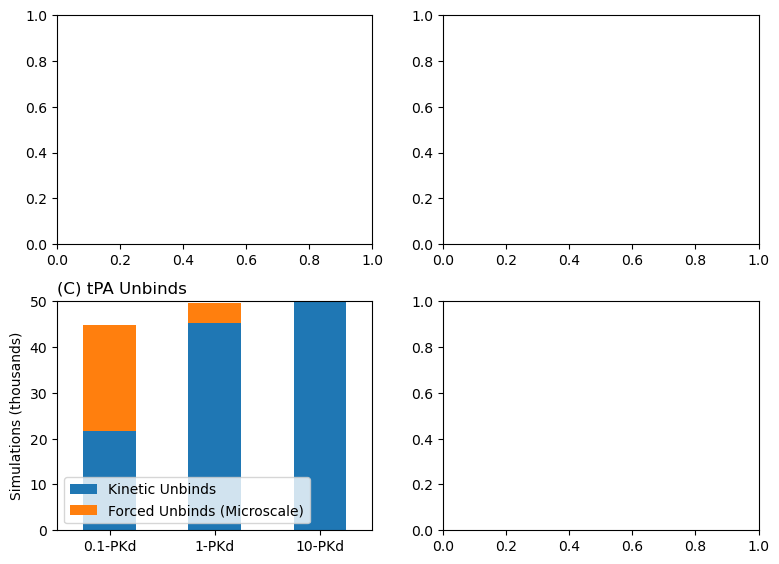

In [25]:
letters = np.array([["(A)", "(B)"], ["(C)", "(D)"]])
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=False,
    sharey=False,
    figsize=(8, 6),
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)

# j = (0, 0)
# axs[j].violinplot(
#     [tPA_leaving_times[i] for i in scenarios["descriptor"]],
#     # showfliers=False,
#     # whis=[0, 100],
#     showmeans=True,
# )
# axs[j].set_title(f"{letters[j]} tPA Leaving Times", loc="left")
# axs[j].set_ylabel("Simulation Time (min)")
# axs[j].set_xticks(
#     np.arange(1, 4),
#     labels=[label[:-3] for label in scenarios["descriptor"]],
#     # rotation=90
# )


# j = (0, 1)
# axs[j].violinplot(
#     [lysis_times[i][lysis_times[i] < 100].flatten() for i in scenarios["descriptor"]],
#     # showfliers=False,
#     # whis=[0, 100],
#     showmeans=True,
# )
# axs[j].set_title(f"{letters[j]} Lysis Time", loc="left")
# axs[j].set_ylabel("Simulation Time (min)")
# axs[j].set_xticks(
#     np.arange(1, 4),
#     labels=[label[:-3] for label in scenarios["descriptor"]],
#     # rotation=90
# )
# # axs[j].tick_params(labelleft=False)

j = (1, 0)
pd.DataFrame(
    [
        [np.count_nonzero(tPA_kinetic_unbind[scen]), np.count_nonzero(tPA_forced_unbind[scen])]
        for scen in scenarios["descriptor"][:3]
    ],
    index=scenarios["descriptor"][:3],
    columns=["Kinetic Unbinds", "Forced Unbinds (Microscale)"],
).plot.bar(ax=axs[j], stacked=True)
axs[j].set_ylim([0, 50_000])
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} tPA Unbinds", loc="left")
axs[j].set_xticks(
    np.arange(3),
    labels=scenarios["descriptor"][:3],
    rotation=0,
)

# j = (1, 1)
# pd.DataFrame(
#     [np.count_nonzero(lysis_times[i][lysis_times[i] < 100]) for i in scenarios["descriptor"]],
#     index=scenarios["descriptor"],
#     columns=["Degraded Fibers"],
# ).plot.bar(ax=axs[j], legend=False)
# axs[j].set_ylabel("Simulations (thousands)")
# axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
# axs[j].set_title(f"{letters[j]} Fibers Degraded", loc="left")
# # axs[j].tick_params(labelleft=False)
# # axs[j].tick_params(labelbottom=False)
# axs[j].set_xticks(
#     np.arange(3),
#     labels=[label[:-3] for label in scenarios["descriptor"]],
#     rotation=0,
# )


fig.savefig("microscale_measure_plots.png", bbox_inches="tight")

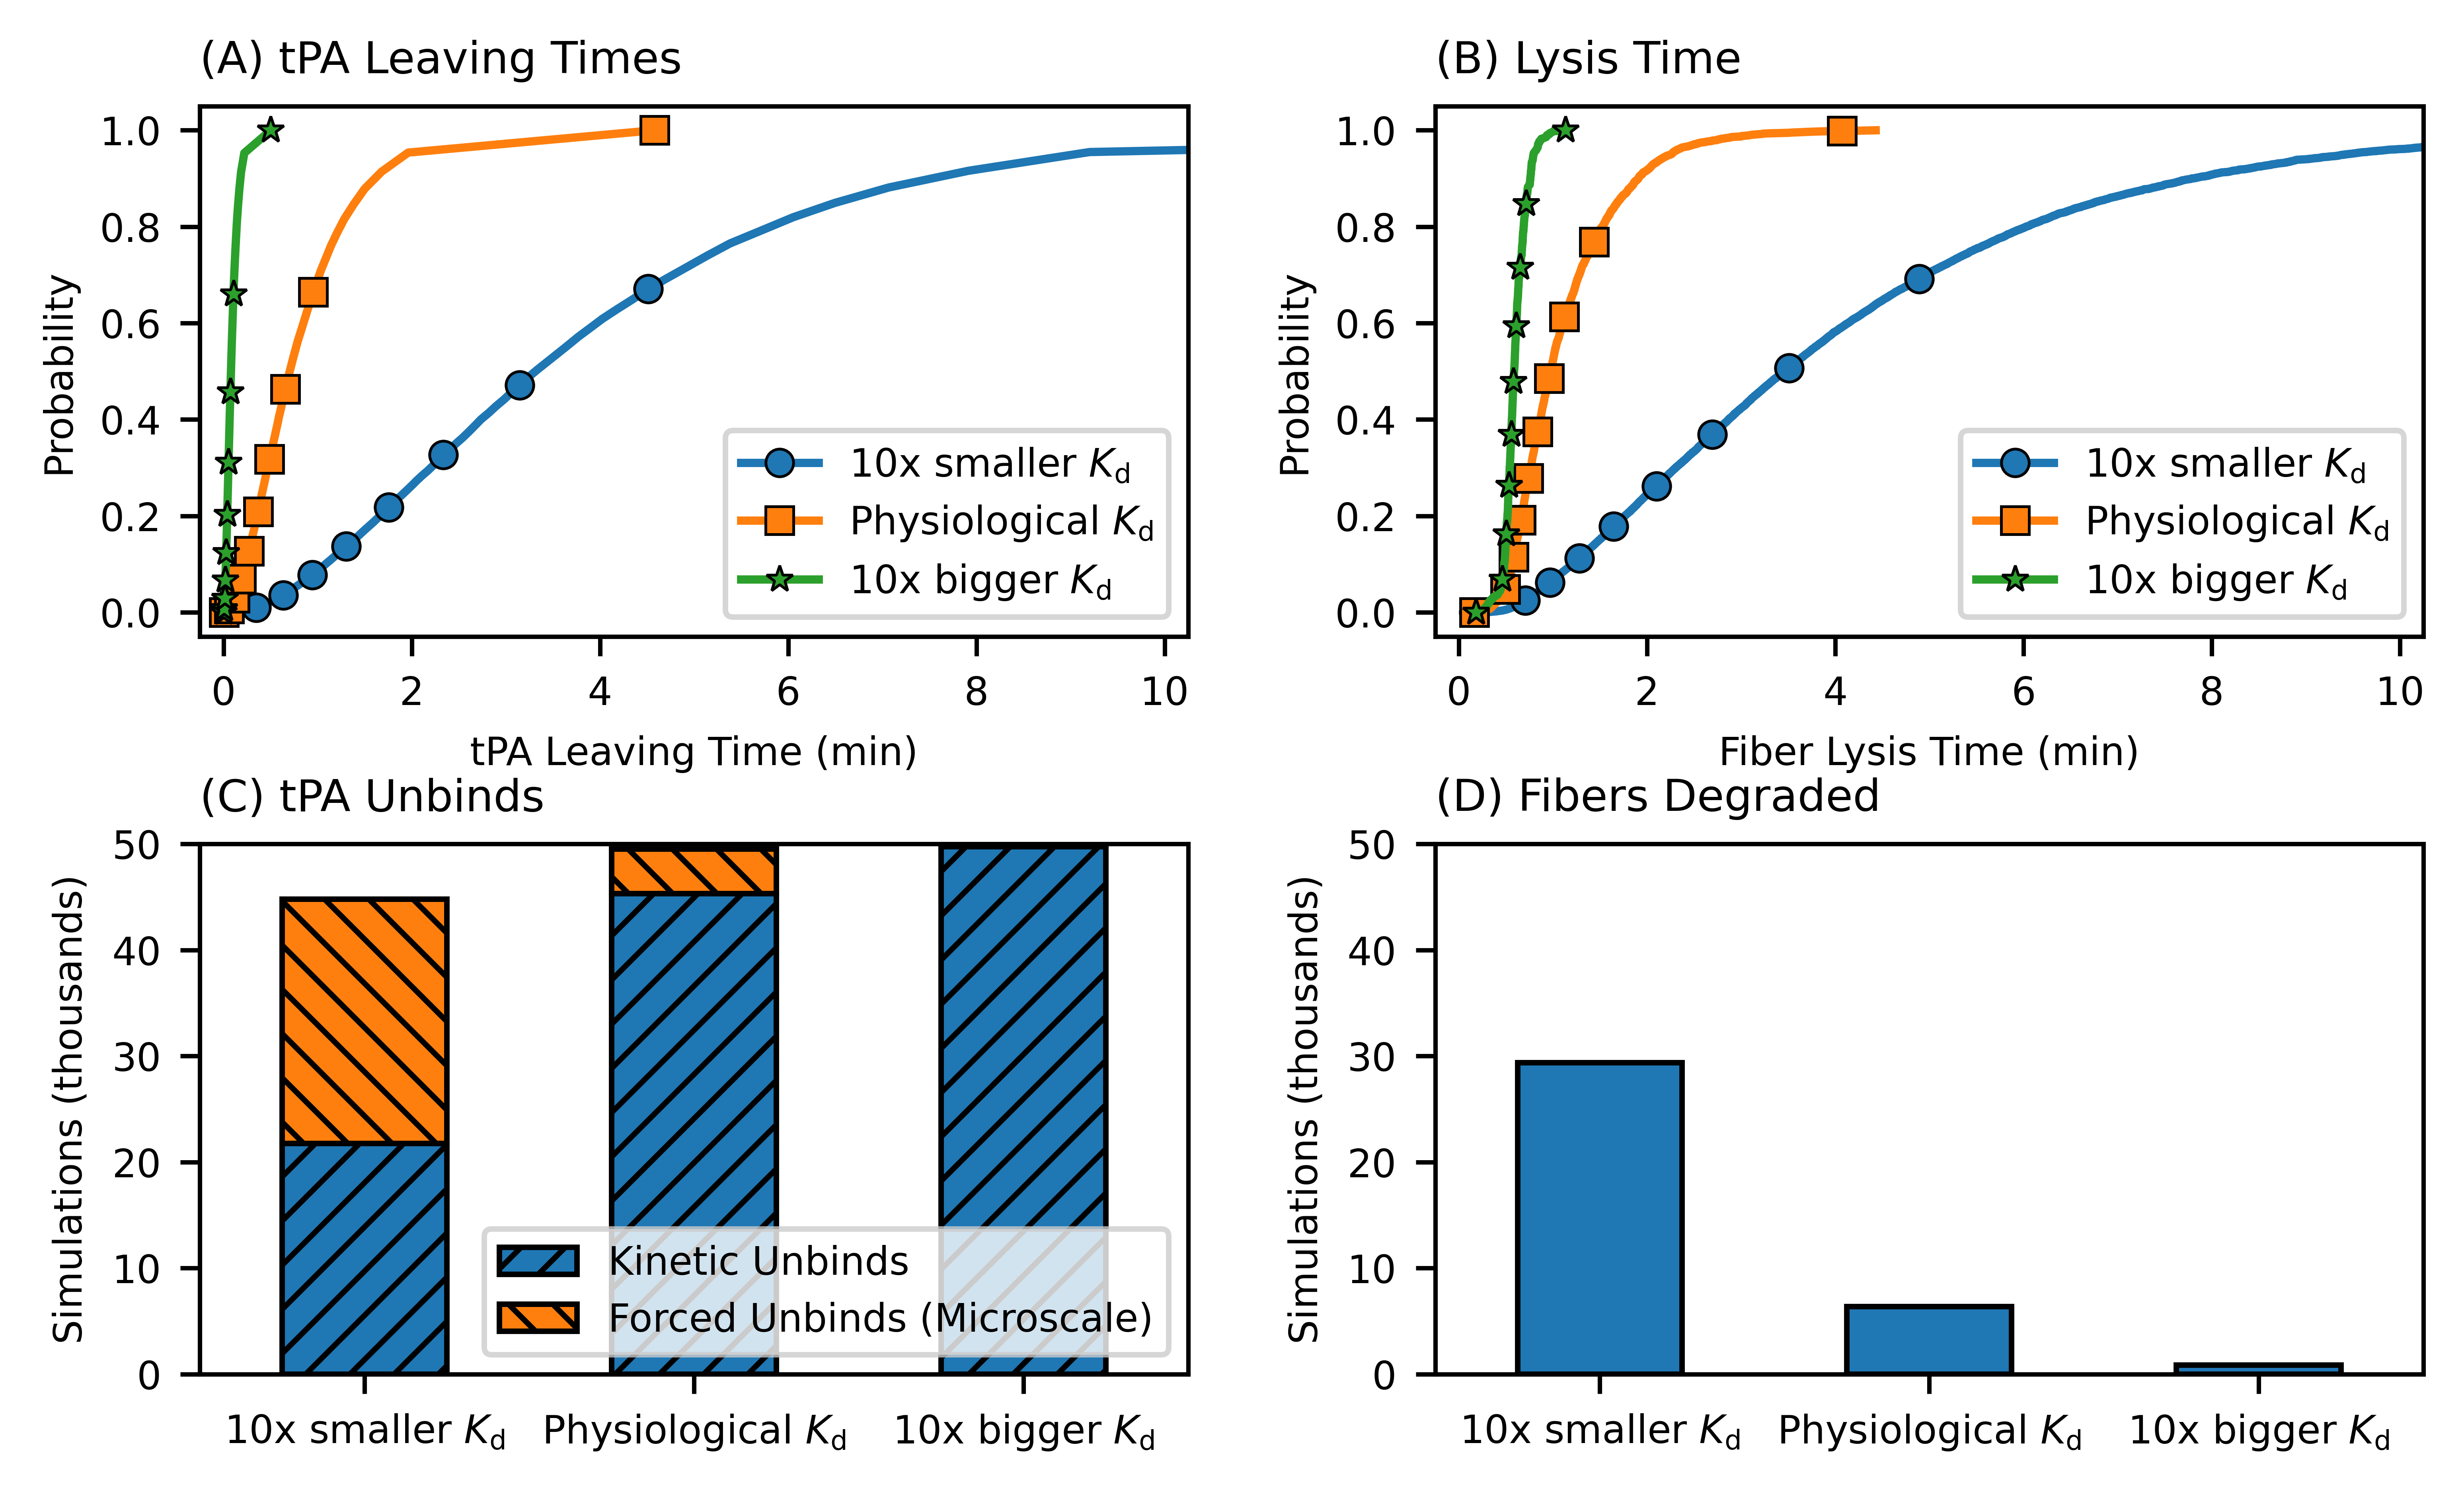

In [21]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

letters = np.array([["(A)", "(B)"], ["(C)", "(D)"]])
markers = ['o', 's', '*', 'd']
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=False,
    sharey=False,
    figsize=(6.5, 4),
    dpi=1000,
    # constrained_layout=True,
)
fig.tight_layout(pad=3.0)

# for i in [2,3]:
#     for j in range(4):
#         axs[i, j].set_axis_off()
#         axs[j, i].set_axis_off()

j = (0, 0)
for i, scen in enumerate(scenarios["descriptor"]):
    values = np.sort(tPA_leaving_times[scen])
    cuml_sum = np.empty(values.shape[0], dtype=float)
    for k in range(values.shape[0]):
        cuml_sum[k] = values[:k].sum()
    cuml_sum = cuml_sum / cuml_sum[-1]
    axs[j].plot(
        values,
        cuml_sum,
        marker=markers[i],
        markevery=values.shape[-1]//9,
        markersize=5,
        markeredgewidth=0.5,
        markeredgecolor="black",
        # showfliers=False,
        # whis=[0, 100],
        # showmedians=True,
        label=scen[:-2] + r"$K_\mathrm{d}$",
    )
axs[j].set_title(f"{letters[j]} tPA Leaving Times", loc="left")
axs[j].set_ylabel("Probability")
axs[j].set_xlabel("tPA Leaving Time (min)")
axs[j].set_xlim(-0.25,10.25)
axs[j].legend()


j = (0, 1)

for i, scen in enumerate(scenarios["descriptor"]):
    values = np.sort(lysis_times[scen][lysis_times[scen] < 100].flatten())
    cuml_sum = np.empty(values.shape[0], dtype=float)
    for k in range(values.shape[0]):
        cuml_sum[k] = values[:k].sum()
    cuml_sum = cuml_sum / cuml_sum[-1]
    axs[j].plot(
        values,
        cuml_sum,
        marker=markers[i],
        markevery=values.shape[-1]//9,
        markersize=5,
        markeredgewidth=0.5,
        markeredgecolor="black",
        # np.sort(lysis_times[i][lysis_times[i] < 100].flatten()),
        # showfliers=False,
        # whis=[0, 100],
        label=scen[:-2] + r"$K_\mathrm{d}$",
    )
axs[j].set_title(f"{letters[j]} Lysis Time", loc="left")
axs[j].set_ylabel("Probability")
axs[j].set_xlabel("Fiber Lysis Time (min)")
axs[j].set_xlim(-0.25,10.25)
# axs[j].tick_params(labelleft=False)
axs[j].legend()

j = (1, 0)
df = pd.DataFrame(
    [
        [np.count_nonzero(tPA_kinetic_unbind[scen]), np.count_nonzero(tPA_forced_unbind[scen])]
        for scen in scenarios["descriptor"]
    ],
    index=scenarios["descriptor"],
    columns=["Kinetic Unbinds", "Forced Unbinds (Microscale)"],
)
df.plot.bar(ax=axs[j], stacked=True, legend=False, linewidth=1, edgecolor="black")
bars = axs[j].patches
hatches = ''.join(h*len(df) for h in ['/','\\',r'|'])
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch*3)
axs[j].set_ylim([0, 50_000])
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} tPA Unbinds", loc="left")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    # labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)
axs[j].legend(loc='lower right')

j = (1, 1)
pd.DataFrame(
    [np.count_nonzero(lysis_times[i][lysis_times[i] < 100]) for i in scenarios["descriptor"]],
    index=scenarios["descriptor"],
    columns=["Degraded Fibers"],
).plot.bar(ax=axs[j], legend=False, linewidth=1, edgecolor="black")
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} Fibers Degraded", loc="left")
# axs[j].tick_params(labelleft=False)
# axs[j].tick_params(labelbottom=False)
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    # labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)


fig.savefig("microscale_measure_plots.png", bbox_inches="tight", )# bbox_inches=mpl.transforms.Bbox([[0, 4], [6.5, 8]]))